<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/notebooks/Klobuchar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNSS Ionosphere delay model
This notebook uses the Klobuchar model with the alpha and beta coeficients transmitted by the GPS network. The alpha and beta values are obtained from the broadcast (BRD) rinex file, from IGS. Since we also need the station position to calculate the ionospheric pierce point, the observation data for a chosen station is obtained from IBGE RBMC.

# Libraries

In [ ]:
!pip install georinex

     |████████████████████████████████| 50 kB 2.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for georinex: filename=georinex-1.15.1-py3-none-any.whl size=52018 sha256=89a6e3ec2e135b9c4ff9f05246129089774a1ed4df8ac06b9c765f8729199c95
  Stored in directory: /root/.cache/pip/wheels/fa/f5/f3/a0b697b437e10561fb6a4546e3d5c4cc5fb073fe746dddd04c
Successfully built georinex


In [ ]:
import georinex as gr
import numpy as np
import xarray as xr
import requests
from datetime import datetime
import erfa
from zipfile import ZipFile
import urllib

from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

# Input data

In [ ]:
#CHANGE THIS TO use other dates. This is the reference date that is going to be used to download the navigation and precise ephemeris files.
#epoch=np.datetime64('2021-01-10T23:45:00') 
epoch=np.datetime64('2021-05-10T23:45:00') 
#epoch=np.datetime64('2020-08-10T23:45:00') 
station="ONRJ"
#station="RJNI"

# Helper functions

In [ ]:
def getDOY(t):
  year=t.astype('datetime64[Y]')
  dayOfYear=((t-year)/np.timedelta64(1,'D')+1).astype(np.int64)
  return dayOfYear

def getBRDC(t):
  doy=getDOY(t)
  year=np.datetime64(t,'Y')#t.astype('datetime64[Y]')
  #baseurl="ftp://gssc.esa.int/gnss/data/daily/{0}/{1:03}/brdc{1:03}0.{2}n.Z".format(str(year),doy,str(year)[:-2])
  
  baseurl="https://igs.bkg.bund.de/root_ftp/IGS/BRDC/{0}/{1:03}/BRDM00DLR_S_{0}{1:03}0000_01D_MN.rnx.gz".format(str(year),doy)
  local_filename = baseurl.split('/')[-1]
  print("Downloading from BKG ", baseurl)
  response = requests.get(baseurl)
  open(local_filename, 'wb').write(response.content)
  print("Saved ",local_filename)
  return local_filename

def getSecsOfWeek(t):
  today=t.astype('datetime64[D]')
  secsOfDay=(t-today)/ np.timedelta64(1, 's')
  dayOfWeek=(today.astype(np.int64) - 3) % 7
  secsOfWeek=secsOfDay+dayOfWeek*24*60*60
  return secsOfWeek

# Downloading data

In [ ]:
#def getRBMC(t,station):
t=epoch
def getRBMC(t,station, rinexversion=3):
    doy=getDOY(t)
    year=np.datetime64(t,'Y')#t.astype('datetime64[Y]')
    if rinexversion==3:
        baseurl="https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados_RINEX3/{0}/{1:03}/{2}00BRA_R_{0}{1:03}0000_01D_15S_MO.crx.gz".format(str(year),doy,station)
    else:
        baseurl="https://geoftp.ibge.gov.br/informacoes_sobre_posicionamento_geodesico/rbmc/dados/{0}/{1:03}/{2}{1:03}1.zip".format(str(year),doy,station.lower() )
    local_filename = baseurl.split('/')[-1]
    print("Downloading from IBGE ", baseurl)
    response = requests.get(baseurl)
    open(local_filename, 'wb').write(response.content)
    print("Saved ",local_filename)
    print("Unzipping")
    with ZipFile(local_filename, 'r') as zipObj:
        outdir=local_filename.split('.')[0]
        zipObj.extractall(outdir)
        files=zipObj.namelist()
        files = [ outdir+ "/"+ sub for sub in files]
    return files
stationFiles=getRBMC(epoch,station,2)

Saved  onrj1301.zip
Unzipping


In [ ]:
#we are using rinex 2 because georinex is incredibly slow for rinex 3 currently.
obsFile=list(filter(lambda f: f[-1]=='d',stationFiles))[0]
obsData=gr.load(obsFile,use='G')
obsData

cc /usr/local/lib/python3.7/dist-packages/georinex/rnxcmp/source/crx2rnx.c -O2 -o/usr/local/lib/python3.7/dist-packages/georinex/rnxcmp/crx2rnx


<xarray.Dataset>
Dimensions:  (sv: 31, time: 5760)
Coordinates:
  * sv       (sv) object 'G01' 'G02' 'G03' 'G04' ... 'G29' 'G30' 'G31' 'G32'
  * time     (time) object 2021-05-10 ... 2021-05-10T23:59:45
Data variables:
    L1       (time, sv) float64 nan 1.299e+08 nan nan ... nan 1.214e+08 nan nan
    L2       (time, sv) float64 nan 1.012e+08 nan nan ... nan 9.463e+07 nan nan
    L5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C1       (time, sv) float64 nan 2.472e+07 nan nan ... nan 2.311e+07 nan nan
    P1       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C2       (time, sv) float64 nan nan nan nan nan ... nan 2.311e+07 nan nan
    P2       (time, sv) float64 nan 2.472e+07 nan nan ... nan 2.311e+07 nan nan
    C5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S1       (time, sv) float64 nan 40.3 nan nan nan ... 45.4 nan 43.3 nan nan
    S2       (time, sv) float64 nan 22.9 nan nan nan ... 30.4 nan 45.3 nan nan
    S5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         onrj1301.21d
    rxmodel:          TRIMBLE NETR8
    position:         [4283638.3579, -4026028.8217, -2466096.8361]

## Reading station's observation data to find the position and the vehicles that we are going to use.

In [ ]:
#Get the latest epoch compared to the given epoch time.
epochData=obsData.sel(time=t, method='ffill')
#Drops vehicles with no data
epochData=epochData.dropna(dim='sv',how='all')
epochData

<xarray.Dataset>
Dimensions:  (sv: 11)
Coordinates:
  * sv       (sv) object 'G02' 'G06' 'G12' 'G13' ... 'G19' 'G24' 'G28' 'G30'
    time     datetime64[ns] 2021-05-10T23:45:00
Data variables:
    L1       (sv) float64 1.321e+08 1.215e+08 1.3e+08 ... 1.135e+08 1.196e+08
    L2       (sv) float64 1.029e+08 9.466e+07 1.013e+08 ... 8.842e+07 9.317e+07
    L5       (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    C1       (sv) float64 2.513e+07 2.312e+07 2.474e+07 ... 2.159e+07 2.275e+07
    P1       (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    C2       (sv) float64 nan 2.312e+07 2.474e+07 ... 2.408e+07 nan 2.275e+07
    P2       (sv) float64 2.513e+07 2.312e+07 2.474e+07 ... 2.159e+07 2.275e+07
    C5       (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    S1       (sv) float64 38.3 44.3 39.9 51.1 41.4 48.3 49.3 52.1 35.6 45.6 45.0
    S2       (sv) float64 22.8 45.1 38.1 41.4 45.5 45.0 49.7 46.3 42.6 29.6 45.9
    S5       (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         onrj1301.21d
    rxmodel:          TRIMBLE NETR8
    position:         [4283638.3579, -4026028.8217, -2466096.8361]

In [ ]:
lonlath=erfa.gc2gd(1,epochData.position) #converting from ITRF 2000.4 to WGS84
print("WGS84 coordinates in radians:", lonlath)
print("WGS84 coordinates in degrees:", lonlath[0]*180/np.pi, lonlath[1]*180/np.pi, lonlath[2])


WGS84 coordinates in radians: (-0.7544069033438886, -0.39960535931091395, 35.636330318177755)
WGS84 coordinates in degrees: -43.22433159713865 -22.895700559324162 35.636330318177755


## Reading the broadcast file, but filtering only for GPS vehicles

In [ ]:
brdcFile=getBRDC(epoch)
brdc=gr.load(brdcFile,use='G') #reads strictly GPS
brdc

Saved  BRDM00DLR_S_20211300000_01D_MN.rnx.gz


<xarray.Dataset>
Dimensions:           (sv: 31, time: 29)
Coordinates:
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
  * time              (time) datetime64[ns] 2021-05-10 ... 2021-05-10T23:59:28
Data variables: (12/28)
    SVclockBias       (time, sv) float64 0.0006936 -0.0006029 ... nan nan
    SVclockDrift      (time, sv) float64 -1.08e-11 -3.183e-12 ... nan nan
    SVclockDriftRate  (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    IODE              (time, sv) float64 72.0 49.0 89.0 73.0 ... nan nan nan nan
    Crs               (time, sv) float64 -31.5 -19.62 35.16 ... nan nan nan
    DeltaN            (time, sv) float64 3.817e-09 4.235e-09 ... nan nan
    ...                ...
    L2Pflag           (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    SVacc             (time, sv) float64 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan
    health            (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    TGD               (time, sv) float64 5.122e-09 -1.77e-08 ... nan nan
    IODC              (time, sv) float64 72.0 49.0 89.0 841.0 ... nan nan nan
    TransTime         (time, sv) float64 7.922e+04 7.922e+04 ... nan nan
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

## Filling missing values

In [ ]:
#nav should never have an empty orbit, so let's fill the NA.
#first we try to propagate forward, so the latest orbit will be used. Then backwards.
brdc=brdc.ffill(dim='time').bfill(dim='time')
brdc

<xarray.Dataset>
Dimensions:           (sv: 31, time: 29)
Coordinates:
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
  * time              (time) datetime64[ns] 2021-05-10 ... 2021-05-10T23:59:28
Data variables: (12/28)
    SVclockBias       (time, sv) float64 0.0006936 -0.0006029 ... 2.143e-05
    SVclockDrift      (time, sv) float64 -1.08e-11 -3.183e-12 ... -5.684e-13
    SVclockDriftRate  (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    IODE              (time, sv) float64 72.0 49.0 89.0 73.0 ... 74.0 58.0 110.0
    Crs               (time, sv) float64 -31.5 -19.62 35.16 ... 57.25 -37.44
    DeltaN            (time, sv) float64 3.817e-09 4.235e-09 ... 4.879e-09
    ...                ...
    L2Pflag           (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SVacc             (time, sv) float64 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    health            (time, sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TGD               (time, sv) float64 5.122e-09 -1.77e-08 ... 4.657e-10
    IODC              (time, sv) float64 72.0 49.0 89.0 ... 74.0 58.0 110.0
    TransTime         (time, sv) float64 7.922e+04 7.922e+04 ... 1.584e+05
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

## Checking the ionospheric correction coeficients for Klobuchar's method

In [ ]:
brdc.ionospheric_corr_GPS

array([ 8.3819e-09,  2.2352e-08, -5.9605e-08, -1.1921e-07,  8.6016e+04,
        6.5536e+04, -1.3107e+05, -4.5875e+05])

# Finding XYZ vehicle position 

In [ ]:
#epochXA is the Xarray of the vehicles on the given epoch
epochXA=brdc.sel(time=epoch, method='pad') 
#copying the timestamps from sp3 to nav data.
epochXA.coords['time'] = [epoch]

In [ ]:
epochXA

<xarray.Dataset>
Dimensions:           (sv: 31, time: 1)
Coordinates:
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
  * time              (time) datetime64[ns] 2021-05-10T23:45:00
Data variables: (12/28)
    SVclockBias       (sv) float64 0.0006928 -0.0006031 ... -0.0001165 2.143e-05
    SVclockDrift      (sv) float64 -1.08e-11 -3.183e-12 ... -2.16e-12 -5.684e-13
    SVclockDriftRate  (sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IODE              (sv) float64 23.0 87.0 50.0 85.0 ... 124.0 74.0 58.0 110.0
    Crs               (sv) float64 -49.06 -60.44 35.16 ... 65.31 57.25 -37.44
    DeltaN            (sv) float64 3.712e-09 4.167e-09 ... 4.108e-09 4.879e-09
    ...                ...
    L2Pflag           (sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SVacc             (sv) float64 2.0 2.0 2.0 2.0 2.0 ... 2.8 2.0 2.0 2.0 2.0
    health            (sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    TGD               (sv) float64 5.122e-09 -1.77e-08 ... -1.304e-08 4.657e-10
    IODC              (sv) float64 23.0 87.0 50.0 853.0 ... 74.0 58.0 110.0
    TransTime         (sv) float64 1.584e+05 1.584e+05 ... 1.584e+05 1.584e+05
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

## Converting the epoch to seconds of GPS week

In [ ]:
secsOfWeek=getSecsOfWeek(epoch)
print("Seconds of week: ",secsOfWeek)
#we should remove the time that the signal took to reach the receiver.

Seconds of week:  171900.0


## Vehicle position helper function

In [ ]:
from numpy import *
#orbit calculation function
#receives the sat
def satPos(satData,t):
  #translated from <https://geodesy.noaa.gov/gps-toolbox/bc_velo.htm> 
  bGM84                    =  3.986004418e14 #3.986005e14 #This is default GM = 3.986004418e14  # [m^3 s^-2]   Mean anomaly at tk
  roota                    =  satData.sqrtA
  toe                      =  satData.Toe
  m0                       =  satData.M0
  e                        =  satData.Eccentricity
  delta_n                  =  satData.DeltaN
  smallomega               =  satData.omega
  cus                      =  satData.Cus
  cuc                      =  satData.Cuc 
  crs                      =  satData.Crs 
  crc                      =  satData.Crc 
  cis                      =  satData.Cis
  cic                      =  satData.Cic 
  idot                     =  satData.IDOT 
  i0                       =  satData.Io 
  bigomega0                =  satData.Omega0 
  earthrate                =  7.2921151467e-5 #This is default bOMEGAE84 7.2921151467e-5
  bigomegadot              =  satData.OmegaDot 

  #Mauricio: I added this to convert the time
  dt=t-toe
  #clock correction calculated from broadcast data.
  dts=satData.SVclockBias + satData.SVclockDrift*dt +satData.SVclockDriftRate*dt*dt #clock delay for each sv
  
  t=t-dts
  A = roota*roota;           #roota is the square root of A
  n0 = np.sqrt(bGM84/(A*A*A));  #bGM84 is what the ICD-200 calls Greek mu
  tk = t - toe;              #t is the time of the pos. & vel. request.
  n = n0 + delta_n;
  mk = m0 + n*tk;
  mkdot = n;
  ek = mk;
  for i in range(0,7):
    ek = mk + e*sin(ek);  #Overkill for small e
  ekdot = mkdot/(1.0 - e*cos(ek));
  #In the line, below, tak is the true anomaly (which is nu in the ICD-200).
  tak = arctan2( sqrt(1.0-e*e)*sin(ek), cos(ek)-e);
  takdot = sin(ek)*ekdot*(1.0+e*cos(tak))/(sin(tak)*(1.0-e*cos(ek)));

  phik = tak + smallomega;
  corr_u = cus*sin(2.0*phik) + cuc*cos(2.0*phik);
  corr_r = crs*sin(2.0*phik) + crc*cos(2.0*phik);
  corr_i = cis*sin(2.0*phik) + cic*cos(2.0*phik);
  uk = phik + corr_u;
  rk = A*(1.0-e*cos(ek)) + corr_r;
  ik = i0 + idot*tk + corr_i;

  ukdot = takdot +2.0*(cus*cos(2.0*uk)-cuc*sin(2.0*uk))*takdot;
  rkdot = A*e*sin(ek)*n/(1.0-e*cos(ek)) + 2.0*(crs*cos(2.0*uk)-crc*sin(2.0*uk))*takdot;
  ikdot = idot + (cis*cos(2.0*uk)-cic*sin(2.0*uk))*2.0*takdot;

  xpk = rk*cos(uk);
  ypk = rk*sin(uk);

  xpkdot = rkdot*cos(uk) - ypk*ukdot;
  ypkdot = rkdot*sin(uk) + xpk*ukdot;

  omegak = bigomega0 + (bigomegadot-earthrate)*tk - earthrate*toe;

  omegakdot = (bigomegadot-earthrate);

  xk = xpk*cos(omegak) - ypk*sin(omegak)*cos(ik);
  yk = xpk*sin(omegak) + ypk*cos(omegak)*cos(ik);
  zk =                   ypk*sin(ik);

  xkdot = ( xpkdot-ypk*cos(ik)*omegakdot )*cos(omegak) - ( xpk*omegakdot+ypkdot*cos(ik)-ypk*sin(ik)*ikdot )*sin(omegak);
  ykdot = ( xpkdot-ypk*cos(ik)*omegakdot )*sin(omegak) + ( xpk*omegakdot+ypkdot*cos(ik)-ypk*sin(ik)*ikdot )*cos(omegak);
  zkdot = ypkdot*sin(ik) + ypk*cos(ik)*ikdot;
  
  res=satData.assign({'X':xk, 'Y':yk, 'Z':zk, 'VX': xkdot,'VY':ykdot,'VZ':zkdot, 'dt':dts, 't':t})
  return res

In [ ]:
vehicles=satPos(epochXA,secsOfWeek)
vehicles

<xarray.Dataset>
Dimensions:           (sv: 31, time: 1)
Coordinates:
  * sv                (sv) <U3 'G01' 'G02' 'G03' 'G04' ... 'G30' 'G31' 'G32'
  * time              (time) datetime64[ns] 2021-05-10T23:45:00
Data variables: (12/36)
    SVclockBias       (sv) float64 0.0006928 -0.0006031 ... -0.0001165 2.143e-05
    SVclockDrift      (sv) float64 -1.08e-11 -3.183e-12 ... -2.16e-12 -5.684e-13
    SVclockDriftRate  (sv) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IODE              (sv) float64 23.0 87.0 50.0 85.0 ... 124.0 74.0 58.0 110.0
    Crs               (sv) float64 -49.06 -60.44 35.16 ... 65.31 57.25 -37.44
    DeltaN            (sv) float64 3.712e-09 4.167e-09 ... 4.108e-09 4.879e-09
    ...                ...
    Z                 (sv) float64 -2.045e+07 1.803e+07 ... 1.14e+07 -1.641e+07
    VX                (sv) float64 -2.522e+03 2.161e+03 ... -1.445e+03 820.0
    VY                (sv) float64 92.67 -69.8 -98.25 ... -222.8 -1.958e+03
    VZ                (sv) float64 -1.279e+03 -1.85e+03 ... -2.67e+03 -2.071e+03
    dt                (sv) float64 0.0006927 -0.0006032 ... -0.0001166 2.142e-05
    t                 (sv) float64 1.719e+05 1.719e+05 ... 1.719e+05 1.719e+05
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

## Computing the coordinates with GeoRinex's function to check accuracy


In [ ]:
epochXA.sel(sv="G01")

<xarray.Dataset>
Dimensions:           (time: 1)
Coordinates:
    sv                <U3 'G01'
  * time              (time) datetime64[ns] 2021-05-10T23:45:00
Data variables: (12/28)
    SVclockBias       float64 0.0006928
    SVclockDrift      float64 -1.08e-11
    SVclockDriftRate  float64 0.0
    IODE              float64 23.0
    Crs               float64 -49.06
    DeltaN            float64 3.712e-09
    ...                ...
    L2Pflag           float64 0.0
    SVacc             float64 2.0
    health            float64 0.0
    TGD               float64 5.122e-09
    IODC              float64 23.0
    TransTime         float64 1.584e+05
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

# Testing GeoRinex orbits. 
For some reason this is not working as expected. Please skip this part.

In [ ]:
sv="G16"
#dt=secsOfWeek-epochXA.sel(sv="G01").Toe.values
#dts=epochXA.sel(sv="G01").SVclockBias.values + epochXA.sel(sv="G01").SVclockDrift.values* (dt)
#epochXA['time']=epochXA['time']-np.timedelta64(int(dts*10e8),'ns')
g1pos=np.concatenate(gr.keplerian2ecef(epochXA.sel(sv=sv)))
print("Georinex:",g1pos)

Georinex: [-4461150.26669054 18611996.4381712  17965142.86491599]


In [ ]:
aux=vehicles.sel(sv=sv)
g1pos2=np.array([aux.X.values, aux.Y.values, aux.Z.values])
print(g1pos2)

[-4461862.31205514 18611336.45589917 17965655.38347489]


In [ ]:
aux=satPos(epochXA,secsOfWeek).sel(sv=sv)
g1pos2=np.array([aux.X.values, aux.Y.values, aux.Z.values])
print(g1pos2)
print(np.linalg.norm(g1pos-g1pos2))

[-4461862.31205514 18611336.45589917 17965655.38347489]
1097.8435561902932


In [ ]:
g1pos-g1pos2

array([ 712.0453646 ,  659.98227203, -512.5185589 ])

In [ ]:
print("Distance between our position and GeoRinex's position.")
print(np.linalg.norm(g1pos-g1pos2))

Distance between our position and GeoRinex's position.
1097.8435561902932


# Vehicles elevation and azimuth

## Filtering vehicles that we see on this epoch

In [ ]:
obsVehicles=vehicles.sel(sv=epochData.sv.values)
obsVehiclesPos=np.dstack([obsVehicles.X.values,obsVehicles.Y.values,obsVehicles.Z.values])[0]
obsVehiclesPos

array([[ 14449765.40676027, -13990669.77248611,  18025818.92188623],
       [ 24074530.3721429 ,  -6631978.14103202,   9199571.1631608 ],
       [ -9252037.95040032, -24620268.67863327,  -4477477.35013632],
       [ 12495948.6834748 , -22850706.15341111,  -4964725.84887698],
       [ 17646351.71841214,   3516770.99447489, -19557636.50239195],
       [   264687.5630155 , -23858200.53217096, -11649770.20589192],
       [ 18257517.67903634,  -7057744.65729132, -17526113.4592843 ],
       [ 19335790.77978396, -13984236.01899442, -11825168.39346322],
       [ -5816077.99458828, -15208933.14323957, -21274499.5227193 ],
       [ 15192847.57975338,  -1713569.52650391, -21157448.74227149],
       [ 26646788.21601358,   -825046.011365  ,  -1218677.743435  ]])

## Plot the vehicles near the receiver

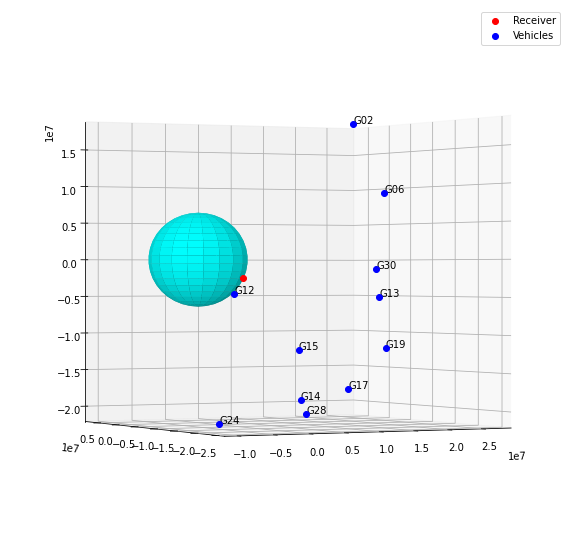

In [ ]:
rotationZ=-75 #change this parameter to rotate the view angle


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d', elev=0)
ax.azim=lonlath[0]*180/np.pi+rotationZ
#WGS84 ellipsoid
a=6378137.0 #This should be in meters
f_inv=298.257223563
b=a*(1-1/f_inv)
divisions=20 #number of divisions on the ellipsoid cell
u = np.linspace(0, 2 * np.pi, divisions)
v = np.linspace(0, np.pi, divisions)
x = a * np.outer(np.cos(u), np.sin(v))
y = a * np.outer(np.sin(u), np.sin(v))
z = b * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='aqua')

#ax.plot([0],[0],[0],'go', label='Earth center') 
ax.plot([epochData.position[0]],[epochData.position[1]],[epochData.position[2]],'ro', label='Receiver',zorder=10) 
ax.plot(obsVehiclesPos[:,0],obsVehiclesPos[:,1],obsVehiclesPos[:,2],'bo', label='Vehicles',zorder=10)
#ax.quiver([epochData.position[0]],[epochData.position[1]],[epochData.position[2]],obsVehiclesPos[:,0], obsVehiclesPos[:,1], obsVehiclesPos[:,2])

#adding labels
for i, txt in enumerate(epochData.sv.values): 
    ax.text(obsVehiclesPos[i,0], obsVehiclesPos[i,1], obsVehiclesPos[i,2], txt)

ax.legend()
plt.show()

## Vehicles elevation and azimuth

In [ ]:
"""Returns the azimuth and elevation of a satellite given the receptor's approximate position. In radians."""
def getElevAzi(xyzRec,xyzSat):
  #xyzSat=np.dstack([df.X.values,df.Y.values,df.Z.values])[0]
  #print(xyzSat)

  rho=np.array(xyzSat)-np.array(xyzRec) #computing the distance vector
  #print(rho)
  rho=rho/np.linalg.norm(rho) #unit vector of the distance
  #print(rho)
  lonlath=erfa.gc2gd(1,xyzRec) #converting the receiver position to lon, lat, height
  lat=lonlath[1]
  lon=lonlath[0]
  rotation=np.array([
    [-sin(lon), -cos(lon)*sin(lat), cos(lon)*cos(lat) ], 
    [cos(lon), -sin(lon)*sin(lat), sin(lon)*cos(lat) ],
    [0, cos(lat),sin(lat)]
  ])
  #print(rotation)
  e=rotation[:,0]
  n=rotation[:,1]
  u=rotation[:,2]
  #print(e)
  #print(rho.dot(u))
  E=np.arcsin(rho.dot(u))
  Az=np.arctan(rho.dot(e)/rho.dot(n))
  #print(E*180/np.pi,Az*180/np.pi)
  #elev_az=np.dstack([E,Az])[0]
  return np.dstack([E,Az])[0]

In [ ]:
elev_az=getElevAzi(epochData.position,obsVehiclesPos)
print("Elevation ",elev_az[:,0]*180/np.pi)
print("Azimuth ",elev_az[:,1]*180/np.pi)

[ 5.47457483  9.19384684  4.44042847 13.63490294  7.49163639 10.40168516
 12.2371622  15.23533049  7.27986057  9.34604913  8.61864108] [  2.19439418  39.90413022  83.38010716 -45.4159222  -52.34633123
  84.76376091 -35.48162192 -38.97670877  39.31063121 -38.85815511
  62.93566799]
Elevation  [ 5.47457483  9.19384684  4.44042847 13.63490294  7.49163639 10.40168516
 12.2371622  15.23533049  7.27986057  9.34604913  8.61864108]
Azimuth  [  2.19439418  39.90413022  83.38010716 -45.4159222  -52.34633123
  84.76376091 -35.48162192 -38.97670877  39.31063121 -38.85815511
  62.93566799]


# Performing Klobuchar's ionospheric modeling

In [ ]:
#      SUBROUTINE KLOBUCHAR(fi,lambda,elev,azimuth,tow,alfa,beta,dIon1)
#C     ==================================================================
#C     Subroutine for computing an Ionospheric range correction for the *
#C     GPS L1 frequency from the parameters broadcasted in the GPS      *
#C     Navigation Message.                                              *
#C     ==================================================================
#C     References:                                                      *
#C     Klobuchar, J.A., (1996) "Ionosphercic Effects on GPS", in        *
#C       Parkinson, Spilker (ed), "Global Positioning System Theory and *
#C       Applications, pp.513-514.                                      *
#C     ICD-GPS-200, Rev. C, (1997), pp. 125-128                         *
#C     NATO, (1991), "Technical Characteristics of the NAVSTAR GPS",    *
#C       pp. A-6-31   -   A-6-33                                        *
#C     ==================================================================
#C     Author : Ola Ovstedal, Department of Mapping Sciences            *
#C                            Agricultural University of Norway         *
#C     Date   : 06.03.2000                  Last modified : 20.11.2000  *
#C     ==================================================================
#C     Input :                                                          *
#C       fi            : Geodetic latitude of receiver          (deg)   *
#C       lambda        : Geodetic longitude of receiver         (deg)   *
#C       elev          : Elevation angle of satellite           (deg)   *
#C       azimuth       : Geodetic azimuth of satellite          (deg)   *
#C       tow           : Time of Week                           (sec)   *
#C       alfa(4)       : The coefficients of a cubic equation           *
#C                       representing the amplitude of the vertical     *
#C                       dalay (4 coefficients - 8 bits each)           *
#C       beta(4)       : The coefficients of a cubic equation           *
#C                       representing the period of the model           *
#C                       (4 coefficients - 8 bits each)                 *
#C     Output:                                                          *
#C       dIon1         : Ionospheric slant range correction for         *
#C                       the L1 frequency                       (metre) *
#C     ==================================================================
#C
#REAL*8 alfa(4),beta(4),fi,lambda,elev,e,azimuth,a,tow,t,
#+       dIon1,psi,lat_i,long_i,lat_m,sf,PER,AMP,x,deg2semi,
#+       semi2rad,deg2rad,pi,c
def KLOBUCHAR(lat,lon,elev,azimuth,tow,alfa,beta):

  c        =  2.99792458e8                  # speed of light
  deg2semi =  1.0/180.0                     # degrees to semicircles
  semi2rad =  np.pi                         # semicircles to radians
  deg2rad  =  np.pi/180.0                   # degrees to radians

  a = azimuth*deg2rad                       # azimuth in radians
  e = elev*deg2semi                         # elevation angle in
                                            # semicircles

  psi = 0.0137 / (e+0.11) - 0.022     # Earth Centered angle

  lat_i = lat*deg2semi + psi*np.cos(a)         # Subionospheric lat
  if (lat_i > 0.416):
    lat_i = 0.416
  elif (lat_i < -0.416):
    lat_i = -0.416
                                            # Subionospheric long
  long_i = lon*deg2semi + (psi*np.sin(a)/np.sin(lat_i*semi2rad))

                                            # Geomagnetic latitude
  lat_m = lat_i + 0.064*np.cos((long_i-1.617)*semi2rad)

  #Check the potency of 10 later
  t = 4.32e4*long_i + tow 
  t = t % 86400.                      # Seconds of day
  if (t > 86400.):  t = t - 86400.
  if (t < 0.):      t = t + 86400.

  sF = 1. + 16.*(0.53-e)**3           # Slant factor

                                            # Period of model
  PER = beta[0] + beta[1]*lat_m + beta[2]*lat_m**2 +beta[3]*lat_m**3

  if (PER < 72000.): PER = 72000.

  x = 2.*pi*(t-50400.)  /  PER          # Phase of the model
                                            # (Max at 14.00 =
                                            # 50400 sec local time)

                                            # Amplitud of the model
  AMP = alfa[0] + alfa[1]*lat_m + alfa[2]*lat_m**2 +alfa[3]*lat_m**3
  if(AMP < 0.): AMP = 0.

                                            # Ionospheric corr.
  if (abs(x) > 1.57):
    dIon1 = sF * (5e-9)
  else:
    dIon1 = sF * (5e-9 + AMP*(1. - x*x/2. + x*x*x*x/24.))

  dIon1 = c * dIon1
  return dIon1

In [ ]:
alfa=brdc.ionospheric_corr_GPS[:4]
beta=brdc.ionospheric_corr_GPS[4:]
print(alfa,beta)

tow=secsOfWeek
ionDelay=[KLOBUCHAR(lonlath[1],lonlath[0],x[0],x[1],tow,alfa,beta) for x in elev_az] 

ionDelay

[ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07] [  86016.   65536. -131070. -458750.]


[5.058820674832284,
 5.051551581180999,
 5.060843612093558,
 5.042884774537964,
 5.054877219900541,
 5.049193064132002,
 5.045610970744877,
 5.039764967791742,
 5.05529111519784,
 5.051254321903748,
 5.052675138808334]

In [ ]:
newdata=epochData.assign({'ionDelay': ionDelay})
newdata

<xarray.Dataset>
Dimensions:   (ionDelay: 11, sv: 11)
Coordinates:
  * sv        (sv) object 'G02' 'G06' 'G12' 'G13' ... 'G19' 'G24' 'G28' 'G30'
    time      datetime64[ns] 2021-05-10T23:59:45
  * ionDelay  (ionDelay) float64 5.059 5.052 5.061 5.043 ... 5.055 5.051 5.053
Data variables:
    L1        (sv) float64 1.292e+08 1.192e+08 1.287e+08 ... 1.149e+08 1.214e+08
    L2        (sv) float64 1.006e+08 9.287e+07 1.002e+08 ... 8.957e+07 9.463e+07
    L5        (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    C1        (sv) float64 2.458e+07 2.268e+07 2.448e+07 ... 2.187e+07 2.311e+07
    P1        (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    C2        (sv) float64 nan 2.268e+07 2.448e+07 ... 2.355e+07 nan 2.311e+07
    P2        (sv) float64 2.458e+07 2.268e+07 2.448e+07 ... 2.187e+07 2.311e+07
    C5        (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
    S1        (sv) float64 39.8 44.9 39.1 50.2 42.6 ... 50.5 51.7 41.1 45.4 43.3
    S2        (sv) float64 22.8 46.7 39.4 40.2 45.7 ... 48.3 44.9 44.1 30.4 45.3
    S5        (sv) float64 nan nan nan nan nan nan nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         onrj1301.21d
    rxmodel:          TRIMBLE NETR8
    position:         [4283638.3579, -4026028.8217, -2466096.8361]

# Bonus: Computing for the entire day

In [ ]:
#finding the intersection between sp3 and nav files
t_begin=max(obsData.time.min(),brdc.time.min())
t_end=min(obsData.time.max(),brdc.time.max())
print("Intersection begins at", t_begin.values, 'and ends at', t_end.values)

Intersection begins at 2021-05-10T00:00:00.000000000 and ends at 2021-05-10T23:59:28.000000000


In [ ]:
alfa=brdc.ionospheric_corr_GPS[:4]
beta=brdc.ionospheric_corr_GPS[4:]
print("Alpha: ",alfa)
print("Beta: ",beta)

#We are going to store the ionospheric data on this object
gpsIonosphere={}
for i in range(1,33):
  gpsIonosphere["G{0:02}".format(i)]=[]
xaxis=[]

t=t_begin.values
while t<t_end.values:
  print("Epoch: ",t)
  xaxis.append(t)
  t+=np.timedelta64(30,'m')
  epochData=obsData.sel(time=t, method='ffill')
  #Drops vehicles with no data from the obs rinex
  epochData=epochData.dropna(dim='sv',how='all')
  #print(epochData.sv.values)
  secsOfWeek=getSecsOfWeek(t)
  #epochXA is the Xarray of the vehicles on the given epoch
  epochXA=brdc.sel(time=t, method='pad') 
  epochXA.coords['time'] = [t]
  vehicles=satPos(epochXA,secsOfWeek)
  obsVehicles=vehicles.sel(sv=epochData.sv.values)
  vehicleNames=epochData.sv.values.tolist()
  obsVehiclesPos=np.dstack([obsVehicles.X.values,obsVehicles.Y.values,obsVehicles.Z.values])[0]
  obsVehiclesPos

  elev_az=getElevAzi(epochData.position,obsVehiclesPos)
  ionDelay=[KLOBUCHAR(lonlath[1],lonlath[0],x[0],x[1],secsOfWeek,alfa,beta) for x in elev_az] 
  for key in gpsIonosphere:
    if key in vehicleNames:
      id=vehicleNames.index(key)
      gpsIonosphere[key].append(ionDelay[id])
    else:
      gpsIonosphere[key].append(NaN)

#print(gpsIonosphere)

Alpha:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07]
Beta:  [  86016.   65536. -131070. -458750.]
Epoch:  2021-05-10T00:00:00.000000000
[ 8.10321172 10.99433408  5.79702662 12.12870411  6.02469322 10.03031275
 10.09633079 14.22407908  9.66351192  7.97204975  6.52319362] [  6.91018682  51.46592766  72.52742676 -31.14607139 -62.73596419
 -79.80775884 -33.76211324 -28.82902833  37.50855797 -50.90720504
  53.61990514]
Epoch:  2021-05-10T00:30:00.000000000
[10.80234311 12.31268348  7.20575558  9.65003681  4.29879313  8.80374255
  7.11853106 12.29116454 11.94903323  6.39047469  3.54680952] [ 12.61630106  69.65121585  59.81199411 -20.80071811 -74.7532537
 -63.49237842 -35.68578714 -28.08675919  38.79339759 -64.23404657
  45.51520043]
Epoch:  2021-05-10T01:00:00.000000000
[13.62627743 13.4070043   9.0386308   7.13683244  2.6591289   7.41342313
  4.17236035 10.43318857 14.34701113  5.05103683] [ 20.56496553 -86.62699922  47.0436905  -12.86551407 -86.62307023
 -49.62440641 -40.24271843 -31.

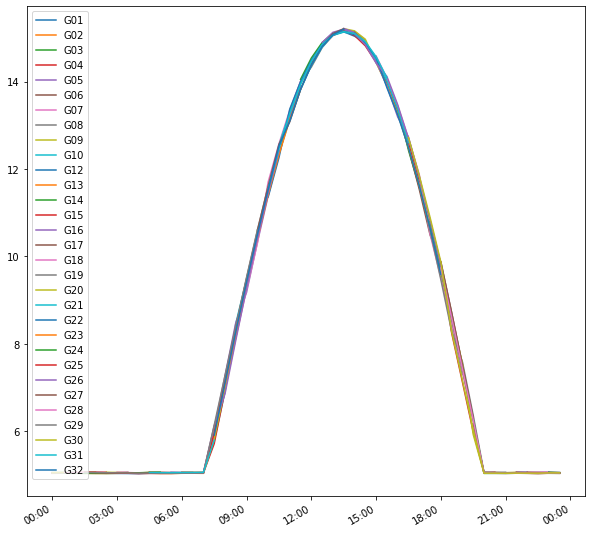

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10,10))

myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)

for i,key in enumerate(gpsIonosphere):
  if not np.isnan( gpsIonosphere[key]).all():
    plt.plot(xaxis,gpsIonosphere[key],label=key)

plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

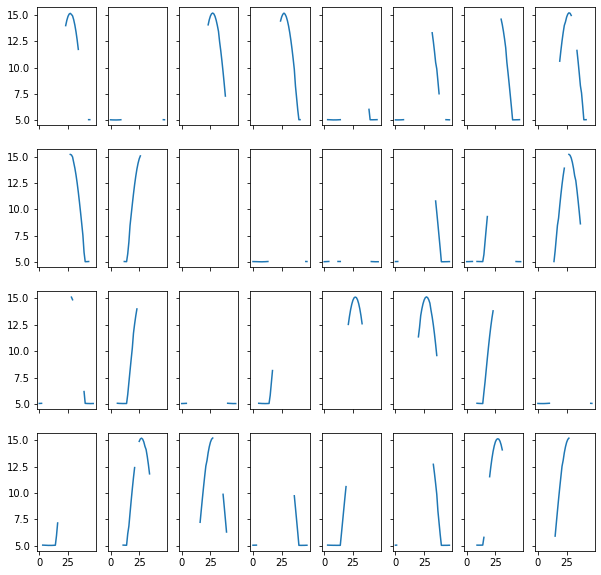

In [ ]:
fig = plt.figure(figsize=(10,10))
fig, axes = plt.subplots(nrows=4, ncols=8, sharex=True, sharey=True, figsize=(10,10))
for i,key in enumerate(gpsIonosphere):
  axes[int(i/8)][i%8].plot(gpsIonosphere[key])
plt.show()

# Bonus: IPP mapping

In [ ]:
def getElevAzi2(xyzRec,xyzSat):
  #xyzSat=np.dstack([df.X.values,df.Y.values,df.Z.values])[0]
  #print(xyzSat)

  rho=np.array(xyzSat)-np.array(xyzRec) #computing the distance vector
  #print(rho)
  rho=rho/np.linalg.norm(rho) #unit vector of the distance
  #print(rho)
  lonlath=erfa.gc2gd(1,xyzRec) #converting the receiver position to lon, lat, height
  lat=lonlath[1]
  lon=lonlath[0]
  rotation=np.array([
    [-sin(lon), -cos(lon)*sin(lat), cos(lon)*cos(lat) ], 
    [cos(lon), -sin(lon)*sin(lat), sin(lon)*cos(lat) ],
    [0, cos(lat),sin(lat)]
  ])
  #print(rotation)
  e=rotation[:,0]
  n=rotation[:,1]
  u=rotation[:,2]
  #print(e)
  #print(rho.dot(u))
  E=np.arcsin(rho.dot(u))
  Az=np.arctan(rho.dot(e)/rho.dot(n))
  print(E*180/np.pi,Az*180/np.pi)
  #elev_az=np.dstack([E,Az])[0]
  return E,Az

def setElevAzi(epochData,obsVehicles):
  obsVehiclesPos=np.dstack([obsVehicles.X.values,obsVehicles.Y.values,obsVehicles.Z.values])[0]
  elev_az=getElevAzi2(epochData.position,obsVehiclesPos)
  res=obsVehicles.assign({'elevation': elev_az[0],'azimuth':elev_az[1]})
  return res


In [ ]:
obsData

<xarray.Dataset>
Dimensions:  (sv: 31, time: 5760)
Coordinates:
  * sv       (sv) object 'G01' 'G02' 'G03' 'G04' ... 'G29' 'G30' 'G31' 'G32'
  * time     (time) object 2021-05-10 ... 2021-05-10T23:59:45
Data variables:
    L1       (time, sv) float64 nan 1.299e+08 nan nan ... nan 1.214e+08 nan nan
    L2       (time, sv) float64 nan 1.012e+08 nan nan ... nan 9.463e+07 nan nan
    L5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C1       (time, sv) float64 nan 2.472e+07 nan nan ... nan 2.311e+07 nan nan
    P1       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    C2       (time, sv) float64 nan nan nan nan nan ... nan 2.311e+07 nan nan
    P2       (time, sv) float64 nan 2.472e+07 nan nan ... nan 2.311e+07 nan nan
    C5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    S1       (time, sv) float64 nan 40.3 nan nan nan ... 45.4 nan 43.3 nan nan
    S2       (time, sv) float64 nan 22.9 nan nan nan ... 30.4 nan 45.3 nan nan
    S5       (time, sv) float64 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    version:          1.0
    interval:         15.0
    rinextype:        obs
    fast_processing:  1
    time_system:      GPS
    filename:         onrj1301.21d
    rxmodel:          TRIMBLE NETR8
    position:         [4283638.3579, -4026028.8217, -2466096.8361]

In [ ]:
setElevAzi(epochData,obsVehicles)

[ 5.47457483  9.19384684  4.44042847 13.63490294  7.49163639 10.40168516
 12.2371622  15.23533049  7.27986057  9.34604913  8.61864108] [  2.19439418  39.90413022  83.38010716 -45.4159222  -52.34633123
  84.76376091 -35.48162192 -38.97670877  39.31063121 -38.85815511
  62.93566799]


<xarray.Dataset>
Dimensions:           (azimuth: 11, elevation: 11, sv: 11, time: 1)
Coordinates:
  * sv                (sv) <U3 'G02' 'G06' 'G12' 'G13' ... 'G24' 'G28' 'G30'
  * time              (time) datetime64[ns] 2021-05-11
  * elevation         (elevation) float64 0.09555 0.1605 ... 0.1631 0.1504
  * azimuth           (azimuth) float64 0.0383 0.6965 1.455 ... -0.6782 1.098
Data variables: (12/36)
    SVclockBias       (sv) float64 -0.0006031 1.454e-05 ... 0.0005734 -0.0004244
    SVclockDrift      (sv) float64 -3.183e-12 3.638e-12 ... -5.002e-12
    SVclockDriftRate  (sv) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
    IODE              (sv) float64 87.0 13.0 88.0 34.0 ... 184.0 3.0 62.0 74.0
    Crs               (sv) float64 -60.44 -44.16 78.38 ... 56.88 64.41 65.31
    DeltaN            (sv) float64 4.167e-09 3.869e-09 ... 4.559e-09 4.625e-09
    ...                ...
    Z                 (sv) float64 1.622e+07 6.491e+06 ... -2.039e+07 1.576e+06
    VX                (sv) float64 1.939e+03 826.7 635.2 ... 1.26e+03 -171.1
    VY                (sv) float64 -150.3 121.4 646.6 ... -417.0 2.406e+03 345.6
    VZ                (sv) float64 -2.163e+03 -3.081e+03 ... 1.059e+03 3.099e+03
    dt                (sv) float64 -0.0006032 1.457e-05 ... 0.0005733 -0.0004244
    t                 (sv) float64 1.728e+05 1.728e+05 ... 1.728e+05 1.728e+05
Attributes:
    ionospheric_corr_GPS:  [ 8.3819e-09  2.2352e-08 -5.9605e-08 -1.1921e-07  ...
    ionospheric_corr_GAL:  [43.5, 0.125, 0.0070801]
    ionospheric_corr_QZS:  [ 8.3819e-09  7.4506e-09 -4.1723e-07 -7.1526e-07  ...
    ionospheric_corr_BDS:  [ 9.3132e-09  2.2352e-08 -2.9802e-07  4.7684e-07  ...
    ionospheric_corr_IRN:  [ 2.1420e-08  2.2352e-07 -5.6028e-06  7.5102e-06  ...
    version:               3.04
    svtype:                ['G']
    rinextype:             nav
    filename:              BRDM00DLR_S_20211300000_01D_MN.rnx.gz

13.711383840433106 83.38010716454879


(0.2393087930203025, 1.4552574006870895)